# Import Libraries and load dataset

In [328]:
# Import necessary modules.

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd# Import Libraries and load dataset

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from google.colab.patches import cv2_imshow

In [329]:
X = np.load('images.npy')

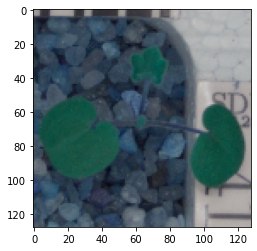

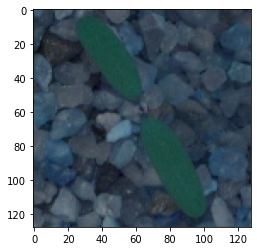

In [330]:
# checking 2 examples of the data

from matplotlib import pyplot as plt

plt.imshow(X[2])
plt.show()
plt.imshow(X[854])
plt.show()

In [331]:
X.shape

(4750, 128, 128, 3)

Meaning of the shape: 4750 images, 128*128 pixel, RGB

In [332]:
# Normalize the data

X = X.astype('float32') / 255.0

## Gaussian blurring

In [333]:
# creating and empty array equivalent to the X dataset

new_x = np.empty((4750, 128, 128, 3)) 
new_x.shape

(4750, 128, 128, 3)

In [334]:
# iterating through each row

for idx, line in enumerate(X):
  new_x[idx] = line.reshape((128, 128, 3))

len(new_x)

4750

In [335]:
# applying 5 pixel blurring on each row 
for idx, img in enumerate(new_x):
  new_x[idx] = cv2.GaussianBlur(img, (5,5), 0)

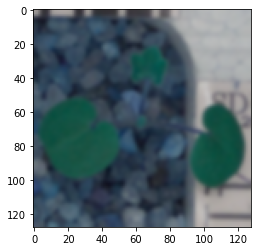

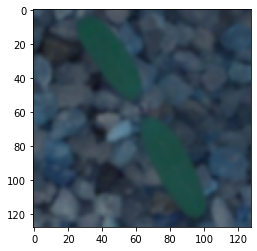

In [336]:
# check the 2 examples we saw above

plt.imshow(new_x[2])
plt.show()
plt.imshow(new_x[854])
plt.show()

It has somewhat blurred the images

## Y data load, and encode

In [337]:
Y_data = pd.read_csv('Labels.csv')

In [338]:
Y_data['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [339]:
# encoding the data for processing

from sklearn.preprocessing import LabelBinarizer

enc = LabelBinarizer()
new_y = enc.fit_transform(Y_data)

In [340]:
print("Shape of y:", new_y.shape)
print("One value of y:", new_y[0])

Shape of y: (4750, 12)
One value of y: [0 0 0 0 0 0 0 0 0 0 1 0]


## Split train, test and validation set

In [341]:
# separate train and test&validation sets 

from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(new_x, new_y, train_size=0.7, random_state=0)

In [342]:
# separate test and validation sets

X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, train_size=0.5, random_state=0)

In [343]:
# check datasets

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(3325, 128, 128, 3)
(3325, 12)
(712, 128, 128, 3)
(712, 12)
(713, 128, 128, 3)
(713, 12)


It's already in compatible shape since the work has been done above

## CNN model building

In [344]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.models import Sequential

# 1st layer
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# 2nd layer
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Global Maxpooling
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax")) # matching the number of the output classes (12)

In [345]:
# Loss and Optimizer
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_26 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_27 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 64)      

In [346]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

## Fit model and evaluate results

In [347]:
batch_size = 32
num_classes = 12 
epochs = 30
num_predictions = 30
history = model.fit(X_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (X_test, y_test),
                    shuffle = True,
                    verbose = 1,
                    callbacks = [early_stopping,model_checkpoint])

Epoch 1/30
104/104 [==============================] - 203s 2s/step - loss: 5.3766 - accuracy: 0.1368 - val_loss: 2.5366 - val_accuracy: 0.1348

Epoch 00001: val_loss improved from inf to 2.53662, saving model to cifar_cnn_checkpoint_01_loss2.5366.h5
Epoch 2/30
104/104 [==============================] - 190s 2s/step - loss: 2.0392 - accuracy: 0.2937 - val_loss: 2.8310 - val_accuracy: 0.1348

Epoch 00002: val_loss did not improve from 2.53662
Epoch 3/30
104/104 [==============================] - 174s 2s/step - loss: 1.7317 - accuracy: 0.3905 - val_loss: 2.9575 - val_accuracy: 0.1348

Epoch 00003: val_loss did not improve from 2.53662
Epoch 4/30
104/104 [==============================] - 176s 2s/step - loss: 1.5807 - accuracy: 0.4320 - val_loss: 2.4162 - val_accuracy: 0.2612

Epoch 00004: val_loss improved from 2.53662 to 2.41617, saving model to cifar_cnn_checkpoint_04_loss2.4162.h5
Epoch 5/30
104/104 [==============================] - 174s 2s/step - loss: 1.4552 - accuracy: 0.4836 - val

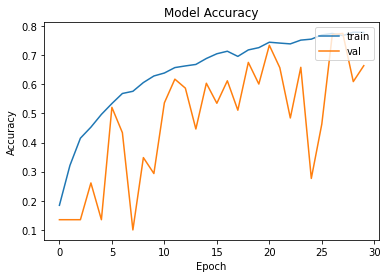

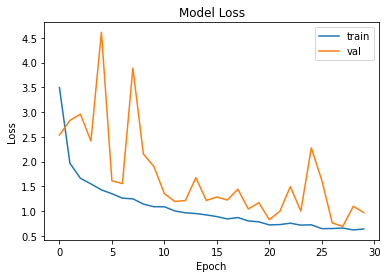

In [348]:
history_df = pd.DataFrame(history.history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [349]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 7s 297ms/step - loss: 0.9712 - accuracy: 0.6643
Test loss: 0.9711627960205078
Test accuracy: 0.6643258333206177


I only had time for 30 epochs but I'm sure more epochs would have improved the accuracy. It is still relatively high

## Check predictions on test set

Predicted label: 7
Softmax Outputs: [[1.6254925e-03 2.1882940e-02 1.3412161e-04 1.7110604e-03 4.2980337e-05
  4.5822091e-02 2.0974419e-04 7.8546441e-01 5.4336200e-04 3.0059989e-03
  4.9850410e-03 1.3457282e-01]]
1.0


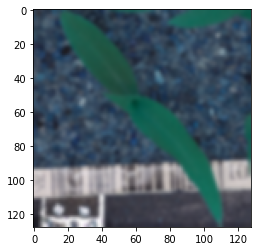

Predicted label: 10
Softmax Outputs: [[0.00279113 0.03587043 0.01604871 0.04823979 0.00203103 0.1693478
  0.00704222 0.08404737 0.14657743 0.1723641  0.23986278 0.07577721]]
1.0


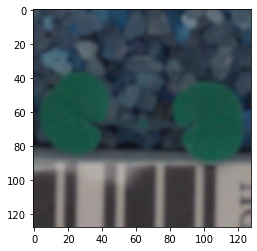

Predicted label: 8
Softmax Outputs: [[1.22296344e-03 8.15737469e-04 1.90943858e-04 1.15367666e-01
  1.45937956e-04 3.91506916e-03 8.94354004e-03 7.50108156e-03
  5.43203294e-01 2.67851204e-01 2.91629694e-03 4.79262508e-02]]
1.0


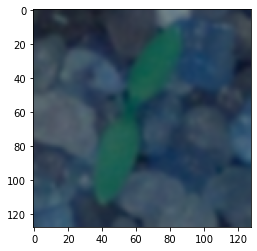

Predicted label: 5
Softmax Outputs: [[0.05385626 0.00351694 0.01062303 0.05939418 0.016745   0.4325628
  0.08031581 0.00759992 0.19126648 0.05131001 0.03880803 0.05400153]]
1.0


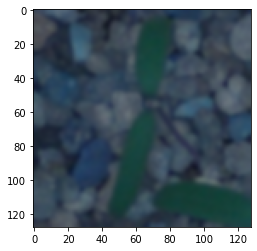

Predicted label: 11
Softmax Outputs: [[1.2085299e-03 4.9395639e-02 5.6413631e-04 1.4970958e-02 8.9166329e-05
  1.4376290e-02 2.4767399e-03 1.1693951e-01 1.6346379e-01 1.1230657e-01
  4.5041572e-03 5.1970452e-01]]
1.0


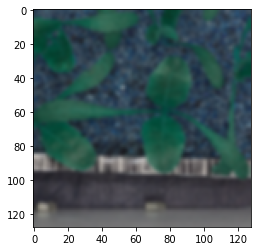

In [350]:
# Check prediction for 2nd, 3rd, 33rd,36th, 59th in test

import matplotlib.pyplot as plt
%matplotlib inline

check = [2,3,33,36,59]
for i in check:
    plt.show()
    plt.imshow(X_test[i].reshape(128, 128, 3))
    y_pred = model.predict(X_test[i].reshape(1, 128, 128, 3))
    print("Predicted label:",  y_pred.argmax())
    print("Softmax Outputs:", y_pred)
    print(y_pred.sum())

## Check predictions on validation set

In [351]:
scores = model.evaluate(X_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 7s 301ms/step - loss: 1.0100 - accuracy: 0.6634
Test loss: 1.0100103616714478
Test accuracy: 0.6633940935134888
